# **1. Importação das bibliotecas requeridas**

In [1]:
# é preciso converter o dataset para RecordIO format para o Linear Learner entender
import io 

import pandas as pd
import numpy as np
import os
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Bibliotecas aws/sagemaker
import boto3
import sagemaker
import sagemaker.amazon.common as smac
from sagemaker.amazon.amazon_estimator import image_uris
from sagemaker.predictor import csv_serializer, json_deserializer
from sagemaker.amazon.amazon_estimator import get_image_uri

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

# **2. Carregando dados da AWS**

### **2.1. Buscando objetos no Glue Catalog**

Foi criado o objeto `glue_client` para acessar objetos do `Glue`. Na célula a seguir recebemos todos os databases existentes neste serviço.

In [2]:
glue_client = boto3.client('glue')

database_list = glue_client.get_databases()
database_list

{'DatabaseList': [{'Name': 'database_platform',
   'CreateTime': datetime.datetime(2021, 4, 6, 11, 7, 50, tzinfo=tzlocal()),
   'CreateTableDefaultPermissions': [{'Principal': {'DataLakePrincipalIdentifier': 'IAM_ALLOWED_PRINCIPALS'},
     'Permissions': ['ALL']}],
   'CatalogId': '793574898187'},
  {'Name': 'sampledb',
   'Description': 'Sample database',
   'Parameters': {'CreatedBy': 'Athena', 'EXTERNAL': 'TRUE'},
   'CreateTime': datetime.datetime(2021, 4, 6, 11, 30, 13, tzinfo=tzlocal()),
   'CreateTableDefaultPermissions': [{'Principal': {'DataLakePrincipalIdentifier': 'IAM_ALLOWED_PRINCIPALS'},
     'Permissions': ['ALL']}],
   'CatalogId': '793574898187'}],
 'ResponseMetadata': {'RequestId': 'd29f5e3b-906d-4a0f-9d9c-3299b66da1d2',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Fri, 09 Apr 2021 19:57:40 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '578',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'd29f5e3b-906d-4a0f-9d9c-3299b66da1d

Em nosso script `Terraform` criamos o `Glue Database` com o nome de **database_platform**, portanto, iremos fazer uma busca sobre o database criado.

In [3]:
database_name_platform = 'database_platform'

for i in range(len(database_list['DatabaseList'])):
    if database_list['DatabaseList'][i]['Name'] == database_name_platform:
        database_glue = database_list['DatabaseList'][i]

database_glue

{'Name': 'database_platform',
 'CreateTime': datetime.datetime(2021, 4, 6, 11, 7, 50, tzinfo=tzlocal()),
 'CreateTableDefaultPermissions': [{'Principal': {'DataLakePrincipalIdentifier': 'IAM_ALLOWED_PRINCIPALS'},
   'Permissions': ['ALL']}],
 'CatalogId': '793574898187'}

Após encontrado o nosso database criado pelo `Terraform`, utilizamos as propriedades `CatalogId` e `Name` do resultado anterior para encontrar as tabelas existentes em nosso database.

In [4]:
table_list = glue_client.get_tables(CatalogId=database_glue['CatalogId'],
                                    DatabaseName=database_glue['Name']
)

table_list

{'TableList': [{'Name': 'cleaned',
   'DatabaseName': 'database_platform',
   'CreateTime': datetime.datetime(2021, 4, 6, 11, 7, 52, tzinfo=tzlocal()),
   'UpdateTime': datetime.datetime(2021, 4, 6, 11, 7, 52, tzinfo=tzlocal()),
   'Retention': 0,
   'StorageDescriptor': {'Columns': [{'Name': 'id',
      'Type': 'string',
      'Comment': '',
      'Parameters': {}},
     {'Name': 'name', 'Type': 'string', 'Comment': '', 'Parameters': {}},
     {'Name': 'abv', 'Type': 'string', 'Comment': '', 'Parameters': {}},
     {'Name': 'ibu', 'Type': 'string', 'Comment': '', 'Parameters': {}},
     {'Name': 'target_fg', 'Type': 'string', 'Comment': '', 'Parameters': {}},
     {'Name': 'target_og', 'Type': 'string', 'Comment': '', 'Parameters': {}},
     {'Name': 'ebc', 'Type': 'string', 'Comment': '', 'Parameters': {}},
     {'Name': 'srm', 'Type': 'string', 'Comment': '', 'Parameters': {}},
     {'Name': 'ph', 'Type': 'string', 'Comment': '', 'Parameters': {}}],
    'Location': 's3://cleaned-buc

Em nosso script `Terraform` criamos o `Glue Table` com o nome de **cleaned**, portanto, iremos fazer uma busca sobre o database criado.

In [5]:
table_name = 'cleaned'

for i in range(len(table_list['TableList'])):
    if table_list['TableList'][i]['Name'] == table_name:
        table_glue_cleaned = table_list['TableList'][i]

table_glue_cleaned

{'Name': 'cleaned',
 'DatabaseName': 'database_platform',
 'CreateTime': datetime.datetime(2021, 4, 6, 11, 7, 52, tzinfo=tzlocal()),
 'UpdateTime': datetime.datetime(2021, 4, 6, 11, 7, 52, tzinfo=tzlocal()),
 'Retention': 0,
 'StorageDescriptor': {'Columns': [{'Name': 'id',
    'Type': 'string',
    'Comment': '',
    'Parameters': {}},
   {'Name': 'name', 'Type': 'string', 'Comment': '', 'Parameters': {}},
   {'Name': 'abv', 'Type': 'string', 'Comment': '', 'Parameters': {}},
   {'Name': 'ibu', 'Type': 'string', 'Comment': '', 'Parameters': {}},
   {'Name': 'target_fg', 'Type': 'string', 'Comment': '', 'Parameters': {}},
   {'Name': 'target_og', 'Type': 'string', 'Comment': '', 'Parameters': {}},
   {'Name': 'ebc', 'Type': 'string', 'Comment': '', 'Parameters': {}},
   {'Name': 'srm', 'Type': 'string', 'Comment': '', 'Parameters': {}},
   {'Name': 'ph', 'Type': 'string', 'Comment': '', 'Parameters': {}}],
  'Location': 's3://cleaned-bucket-platform/processing-sucess',
  'InputFormat':

Analisando o resultado da célula anterior, é possível verificar que a fonte de dados para a tabela `cleaned` está na chave `Location`, que contem a informação do `bucket S3` denominado `cleaned-bucket-platform` e a pasta `processing-sucess`. Exatamente o bucket S3 que criamos utilizando o script `Terraform`.

**Observação**: Foi criado a pasta `processing-sucess` para receber os dados processados pelo fluxo de _streaming_ de dados corretamente. Caso ocorra algum tipo de falha neste processamento, os logs são gravados na pasta `processing-failed`. Desta forma, os diretórios ficam bem separados facilitando tanto a consulta dos dados, quanto a análise de algum problema no processamento do fluxo.

In [6]:
s3_location_table = table_glue_cleaned['StorageDescriptor']['Location']
s3_location_table

's3://cleaned-bucket-platform/processing-sucess'

Utilizamos o `split('/')` para capturar o nome do bucket e a pasta com a fonte dos dados do `Glue Table`.

In [7]:
bucket_name = s3_location_table.split('/')[2]
folder_data = s3_location_table.split('/')[3]

print(bucket_name)
print(folder_data)

cleaned-bucket-platform
processing-sucess


### **2.2. Capturando dados do bucket S3**

Neste momento, como tenho a informação da fonte de dados, é possível criar um objeto client do `Amazon S3` para acessar os buckets existentes e buscar os dados necessários

In [8]:
s3_client = boto3.client('s3')

In [9]:
# Obtendo uma lista de objetos do bucket
obj_list = s3_client.list_objects(Bucket=bucket_name)

files=[]
for contents in obj_list['Contents']:
    if contents['Key'].split('/')[0].split('/')[0] == folder_data:
        files.append(contents['Key'])
    
print(len(files))

238


In [10]:
# Visualizar um exemplo do dado
file_name=files[0]

print(file_name)

processing-sucess/202104061114_clean.csv


In [11]:
# captura um objeto do S3 como exemplo para visualizar os metadados 
data_object = s3_client.get_object(Bucket=bucket_name, Key=file_name)

# visualizando o conteúdo do objeto
display(data_object)

{'ResponseMetadata': {'RequestId': 'Q0AV7660PPY8WSBY',
  'HostId': 'qGsjcdg3Esp6eWCihBGYa0P0BWxkB2MaskOzTdNiGynK2SksohTIFU44XicQYPNR9YPleSuhjYc=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'qGsjcdg3Esp6eWCihBGYa0P0BWxkB2MaskOzTdNiGynK2SksohTIFU44XicQYPNR9YPleSuhjYc=',
   'x-amz-request-id': 'Q0AV7660PPY8WSBY',
   'date': 'Fri, 09 Apr 2021 19:57:42 GMT',
   'last-modified': 'Tue, 06 Apr 2021 11:14:22 GMT',
   'etag': '"327764b0082a63b8c9cf3a7317bf75e8"',
   'accept-ranges': 'bytes',
   'content-type': 'binary/octet-stream',
   'content-length': '51',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'AcceptRanges': 'bytes',
 'LastModified': datetime.datetime(2021, 4, 6, 11, 14, 22, tzinfo=tzutc()),
 'ContentLength': 51,
 'ETag': '"327764b0082a63b8c9cf3a7317bf75e8"',
 'ContentType': 'binary/octet-stream',
 'Metadata': {},
 'Body': <botocore.response.StreamingBody at 0x7f8df59c9550>}

In [12]:
# Verificando o tipo de dados da chave "Body" para leitura posterior
data_body = data_object["Body"].read()
print('Data type: ', type(data_body))

Data type:  <class 'bytes'>


* É do tipo de dado `bytes`, para realizar a leitura devemos utilizar [io.BytesIO(file)](https://docs.python.org/3/library/io.html#binary-i-o).

In [13]:
# Leitura dos dados no formato bytes
data_stream = io.BytesIO(data_body)

### **Criação do DataFrame com os dados do S3**

Neste momento, tenho uma lista contendo os dados armazenados no S3. Agora será preciso criar um DataFrame, com as colunas nomeadas abaixo e seus respectivos tipos de dados.

Irei iterar sobre a lista de dados e irei fazer um append no DataFrame em cada arquivo de dados.

Por fim, será apresentado o DataFrame final.

In [14]:
list_columns = ['id', 'name', 'abv', 'ibu', 'target_fg', 'target_og', 'ebc', 'srm', 'ph']

# Criando dicionário de chave e tipo para a criação do DataFrame
dict_type    = {'id': 'int32', 'name': 'string', 'abv': 'float32', 'ibu': 
                'float32', 'target_fg': 'float32', 'target_og': 'float32', 
                'ebc': 'float32', 'srm': 'float32', 'ph': 'float32'}

df = pd.DataFrame(columns=list_columns)

for file in files:

    # obtendo um objeto s3
    data_object = s3_client.get_object(Bucket=bucket_name, Key=file)
    
    # lendo os dados da chave "Body"
    data_body = data_object["Body"].read()
    
    # lendo dados em bytes
    data_stream = io.BytesIO(data_body)
    
    counties_df = pd.read_csv(data_stream, names=list_columns, dtype=dict_type, header=None, delimiter=",") 

    df = counties_df.append(df, ignore_index=True)

df.head()

,id,name,abv,ibu,target_fg,target_og,ebc,srm,ph
0,182,All Day Long - Prototype Challenge,2.8,30.0,1012.0,1032.5,42.0,21.0,4.4
1,275,Sidewalk Shark,5.2,22.0,1008.0,1055.0,7.0,4.0,3.8
2,225,Paradox Islay 2.0,13.0,100.0,1112.0,1015.0,300.0,152.0,4.4
3,146,Nelson Sauvin,7.5,75.0,1013.0,1068.0,30.0,15.0,4.4
4,91,Dead Pony Club,3.8,35.0,1012.0,1040.0,25.0,12.7,4.4


In [15]:
# Exibindo as colunas do dataframe
df.columns

Index(['id', 'name', 'abv', 'ibu', 'target_fg', 'target_og', 'ebc', 'srm',
       'ph'],
      dtype='object')

### **Excluindo as colunas não utilizadas para a modelagem**

In [16]:
df.drop(columns=['id', 'name'], axis=1, inplace=True)

In [17]:
df.head()

,abv,ibu,target_fg,target_og,ebc,srm,ph
0,2.8,30.0,1012.0,1032.5,42.0,21.0,4.4
1,5.2,22.0,1008.0,1055.0,7.0,4.0,3.8
2,13.0,100.0,1112.0,1015.0,300.0,152.0,4.4
3,7.5,75.0,1013.0,1068.0,30.0,15.0,4.4
4,3.8,35.0,1012.0,1040.0,25.0,12.7,4.4


In [18]:
df.tail()

,abv,ibu,target_fg,target_og,ebc,srm,ph
233,4.5,37.0,1012.0,1047.0,20.0,10.0,4.2
234,8.2,70.0,1013.0,1076.0,16.0,8.0,4.4
235,6.7,67.0,1013.0,1064.0,19.0,9.5,4.4
236,13.2,85.0,1023.0,1125.0,140.0,71.0,4.4
237,4.4,70.0,1012.0,1045.0,30.0,15.0,4.4


**Excluindo dados duplicados**

Como a Punk API existem apenas 325 dados únicos, e o fluxo de _streaming_ de dados busca dados aleatórios, a possibilidade de buscar um dado repetido é alta. Portanto, é necessário a exclusão de dados duplicados para o treinamento correto.

In [19]:
df.drop_duplicates(inplace=True)

**Verificando se existem dados nulos ou NaN**

In [20]:
df.isnull().sum()

abv          0
ibu          0
target_fg    0
target_og    0
ebc          2
srm          2
ph           0
dtype: int64

In [21]:
df.isna().sum()

abv          0
ibu          0
target_fg    0
target_og    0
ebc          2
srm          2
ph           0
dtype: int64

**Após a verificação de dados nulos, será feita a exclusão**

In [22]:
df.dropna(inplace=True)

In [23]:
df.isnull().sum()

abv          0
ibu          0
target_fg    0
target_og    0
ebc          0
srm          0
ph           0
dtype: int64

In [24]:
df.isna().sum()

abv          0
ibu          0
target_fg    0
target_og    0
ebc          0
srm          0
ph           0
dtype: int64

In [25]:
# reiniciando a contagem dos indexes após a exclusão de dados nulos e/ou ausentes
df.reset_index(drop=True, inplace=True)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   abv        151 non-null    float32
 1   ibu        151 non-null    float32
 2   target_fg  151 non-null    float32
 3   target_og  151 non-null    float32
 4   ebc        151 non-null    float32
 5   srm        151 non-null    float32
 6   ph         151 non-null    float32
dtypes: float32(7)
memory usage: 4.3 KB


**Exibindo as informações estatísticas da base de dados**

In [27]:
df.describe()

,abv,ibu,target_fg,target_og,ebc,srm,ph
count,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000
mean,7.956292,72.437088,1015.774841,1066.500000,73.477478,37.080406,4.439074
std,4.709277,129.195740,17.457064,27.307945,105.258606,53.198406,0.345634
min,2.500000,0.000000,1000.000000,1007.000000,5.000000,3.000000,3.200000
25%,5.200000,35.000000,1009.000000,1048.000000,15.000000,7.810000,4.400000
50%,7.200000,50.000000,1012.000000,1065.000000,30.000000,15.000000,4.400000
75%,9.000000,70.000000,1015.000000,1077.500000,70.500000,35.500000,4.400000
max,41.000000,1157.000000,1125.000000,1157.000000,600.000000,305.000000,5.300000


## **3. Análise Exploratória dos Dados (EDA)**

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


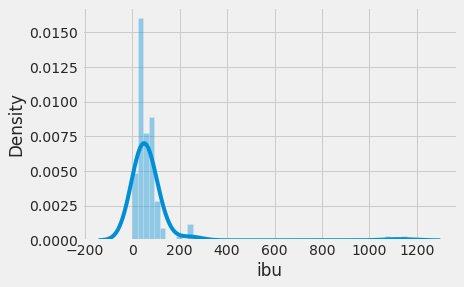

In [28]:
# Verificando a distribuição da variável target 'ibu'
sns.distplot(df['ibu']);

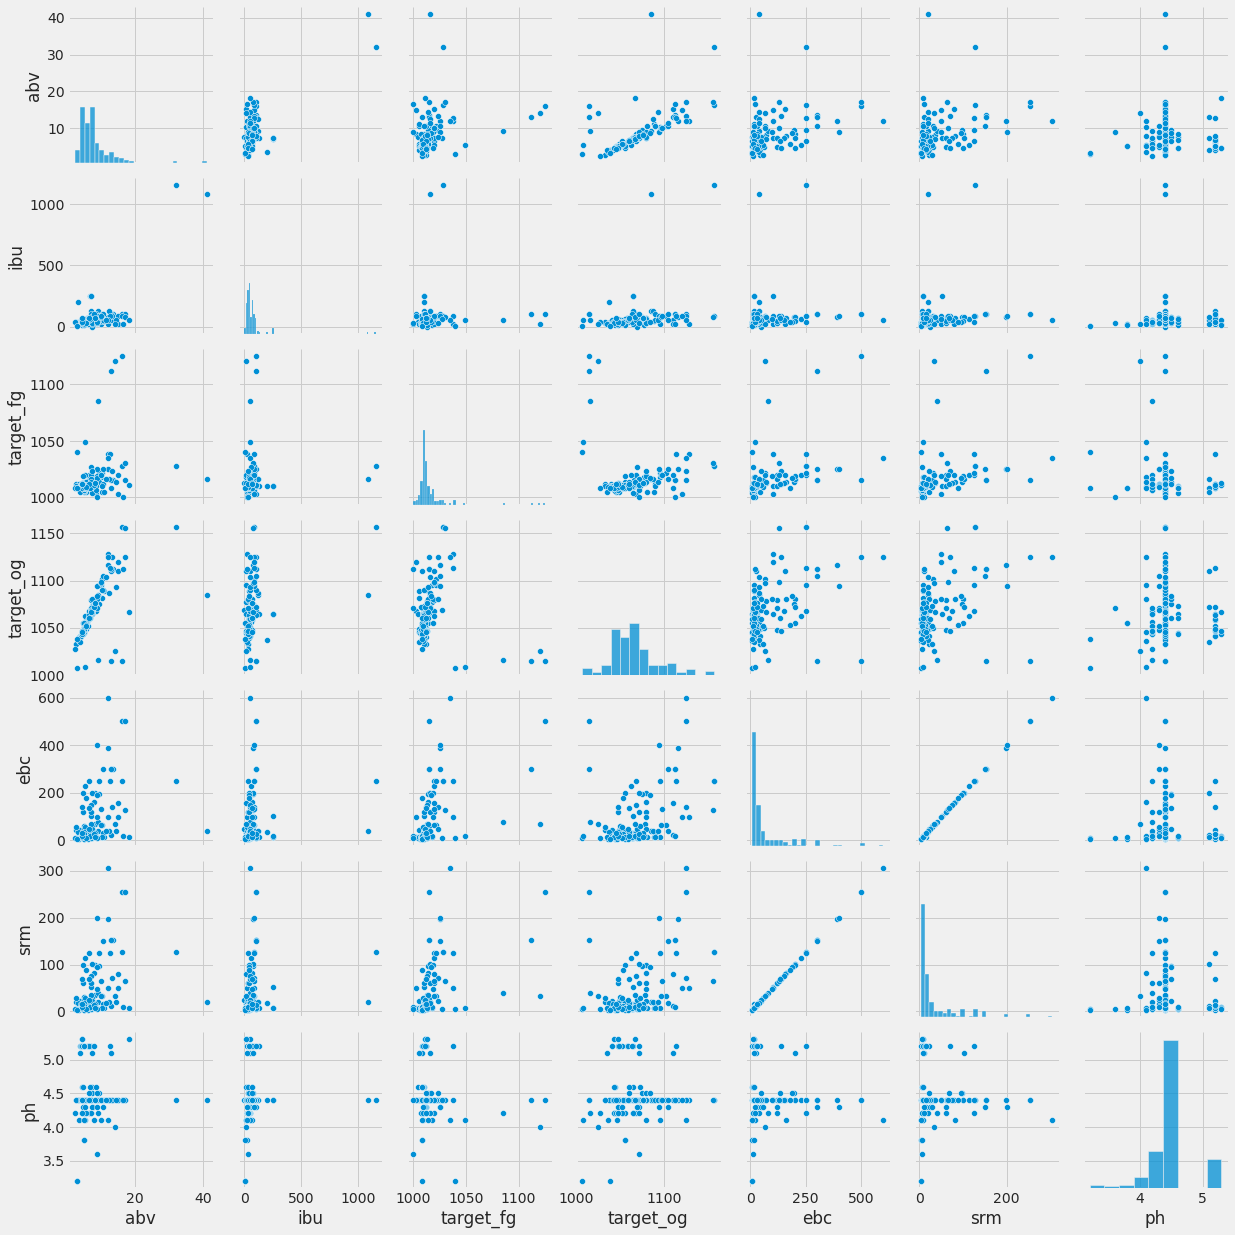

In [29]:
# Verificando os gráficos das variáveis em pares
sns.pairplot(df);

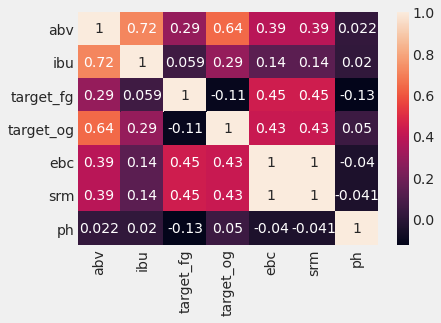

In [30]:
# Verificando a correlação dos dados
sns.heatmap(df.corr(), annot=True);

**Observação**: Como realizamos dois treinamentos localmente com os mesmos dados, o primeiro com todas as features e o segundo apenas com a feature `abv` que possui maior correlação com a nossa variável target e obtivemos um melhor resultado com o modelo que utilizou todas as features, iremos apenas treinar o modelo de regressão linear múltipla.

# **4. Pré-processamento dos dados**

#### **Selecionando as features e o target para o treinamento do modelo**

Neste momento, descartamos as colunas `id` e `name`, pois não serão utilizadas no treinamento.

In [31]:
# Selecionando as features
features_names = ['abv', 'target_fg', 'target_og', 'ebc', 'srm', 'ph']
features = df[features_names]

target = df['ibu']

In [32]:
len(features_names)

6

In [33]:
features.shape

(151, 6)

In [34]:
target.head()

0     30.0
1     22.0
2    100.0
3     75.0
4     35.0
Name: ibu, dtype: float32

# **5. Treinamento dos modelos**

## **5.1. Regressão Linear/Linear Learner (Múltipla)**

Na etapa abaixo a variável `X` irá receber nossas features (variáveis independentes) para o treinamento e a variável `y` receberá a a variável dependente que será nosso target.

Ambas variáveis receberão os dados convertidos numpy array com o tipo de dado float32.

Por fim, será realizado a separação entre base de treinamento e base de teste. Utilizei a proporção de 80% para treinamento e 20% para teste.

* X_train: features para treinamento do modelo.
* y_train: target para treinamento do modelo.
* X_test: features para teste do modelo.
* y_test: target para teste do modelo.

**Observação**: Como a base total de dados é pequena, optei por não ter uma base de validação, uma vez que teria poucas amostras para treinamento e teste.

In [35]:
X = np.array(features).astype('float32')
y = np.array(target).astype('float32')

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, 
                                                    random_state=42)

In [36]:
X_train.shape

(120, 6)

### **5.1.1. Upload dados pré-processados para o S3**

Nesta etapa se faz necessário, após o tratamento dos dados, realizar o upload dos dados no s3 para a posterior leitura e treinamento do modelo.

In [37]:
# Criando sessão SageMaker
sagemaker_session = sagemaker.Session()

# Prefixo para o diretório no bucket S3
prefix = 'model-sagemaker'

role = sagemaker.get_execution_role()
print(role)

arn:aws:iam::793574898187:role/iam_platform_role


In [38]:
# Criação de um objeto bytes para trabalhar como buffer
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, X_train, y_train)
buf.seek(0)

# Sub-pasta para o arquivo de treinamento que será enviado ao S3 
key = 'linear-train-data'

# Upload arquivo de dado para o S3
boto3.resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)
s3_train_data = 's3://{}/{}/train/{}'.format(bucket_name, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

uploaded training data location: s3://cleaned-bucket-platform/model-sagemaker/train/linear-train-data


In [39]:
# Criação de um objeto bytes para trabalhar como buffer
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, X_train, y_train)
buf.seek(0)

# Sub-pasta para o arquivo de treinamento que será enviado ao S3 
key = 'linear-test-data'

boto3.resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'test', key)).upload_fileobj(buf)
s3_test_data = 's3://{}/{}/test/{}'.format(bucket_name, prefix, key)
print('uploaded training data location: {}'.format(s3_test_data))

uploaded training data location: s3://cleaned-bucket-platform/model-sagemaker/test/linear-test-data


In [40]:
# Sub-pasta para os artefatos de saída do modelo, exemplo: modelo treinado
output_location = 's3://{}/{}/output'.format(bucket_name, prefix)
print('Training artifacts will be uploaded to: {}'.format(output_location))

Training artifacts will be uploaded to: s3://cleaned-bucket-platform/model-sagemaker/output


Na célula abaixo é criado um objeto chamado `container` que recupera uma imagem do modelo `linear-learner` já existente do SageMaker. 

A seguir, iremos utilizar este objeto `container` como um dos parâmetros para instanciar um objeto `Estimator`. Outros parâmetros necessários são: quantidade de instâncias para o treinamento, o tipo da instância (configuração), a localização da saída dos artefatos do treinamento.

In [41]:
container = image_uris.retrieve('linear-learner', 
                                boto3.Session().region_name)

mult_linear = sagemaker.estimator.Estimator(container,
                                           role, 
                                           instance_count = 1, 
                                           instance_type = 'ml.c4.xlarge',
                                           output_path = output_location,
                                           sagemaker_session = sagemaker_session)

A seguir iremos configurar alguns hiperparâmetros para o treinamento.

Observação: Existem mais hiperparâmetros que podem ser utilizados, entretanto, os escolhidos foram os mais utilizados por padrão deste modelo.

In [42]:
mult_linear.set_hyperparameters(feature_dim = len(features_names),
                           predictor_type = 'regressor',
                           mini_batch_size = 20,
                           epochs = 5,
                           num_models = 10,
                           loss = 'absolute_loss')

Realizando o treinamento do modelo `linear-learner`.

In [43]:
%time
mult_linear.fit({'train': s3_train_data})

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs
2021-04-09 19:57:58 Starting - Starting the training job...
2021-04-09 19:57:59 Starting - Launching requested ML instancesProfilerReport-1617998277: InProgress
......
2021-04-09 19:59:12 Starting - Preparing the instances for training.........
2021-04-09 20:00:54 Downloading - Downloading input data...
2021-04-09 20:01:21 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[04/09/2021 20:01:27 INFO 140452992677696] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method'

# **6. Deploy do Modelo e Criação de Endpoint**

Para que seja possível realizar inferências utilizando o modelo treinado se faz necessário o seu deploy.

Realizando o deploy do modelo de regressão linear múltipla

A implantação é realizada em uma instância da `Amazon EC2`, os parâmetros do método deploy() são as configurações da Amazon EC2.

In [44]:
mult_linear_regressor = mult_linear.deploy(initial_instance_count = 1,
                                            instance_type = 'ml.m4.xlarge')

--------------!

Observe que serializamos nosso modelo para garantir que possamos processar nossos resultados e compará-los com os resultados reais do teste `y`. Depois que seu endpoint tiver sido criado com sucesso, você deverá ver uma mensagem de exclamação e um endpoint aparecerá quando você verificar Endpoints ativos no serviço SageMaker.

In [45]:
mult_linear_regressor.serializer = csv_serializer
mult_linear_regressor.deserializer = json_deserializer

Verificando o nome do endpoint criado após a implantação do modelo treinado.

In [46]:
mult_linear_regressor.endpoint_name

'linear-learner-2021-04-09-20-02-46-335'

# **7. Avaliação do Modelo**

A seguir será apresentada uma breve explicação das métricas utilizadas para a avaliação do modelo.

**MAE** (_Mean Absolute Error_):
* O MAE, ou Erro Absoluto Médio é a métrica mais simples de se entender. Essa métrica consiste em calcular o residual de cada ponto, onde valores residuais negativos e positivos não se anulam. Após esse agrupamento, calculamos então a média desses ‘residuais’.

**MSE** (_Mean Squared Error_):
* Em estatística, o erro quadrático médio (MSE) de um estimador (de um procedimento para estimar uma quantidade não observada) mede a média dos quadrados dos erros - ou seja, a diferença quadrática média entre os valores estimados e o que é estimado. MSE é uma função de risco, correspondendo ao valor esperado da perda de erro quadrada

**RMSE** (_Root Mean Squared Error_):
* O desvio médio quadrático ou erro quadrático médio é uma medida freqüentemente usada das diferenças entre os valores previstos por um modelo ou estimador e os valores observados. É aplicado a raiz quadrada no resultado da MSE.

**R2 Square**:
* R-quadrado (R2) é uma medida estatística que representa a proporção da variância para uma variável dependente que é explicada por uma variável independente ou variáveis ​​em um modelo de regressão.

Funções para avaliar o modelo treinado

In [47]:
def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

### **7.1. Avaliação Regressão Linear (Múltipla)**

Realizando a inferência dos dados de testes.

In [48]:
pred_test = mult_linear_regressor.predict(X_test)

The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [49]:
pred_test

{'predictions': [{'score': 54.730712890625},
  {'score': 48.421142578125},
  {'score': 74.343505859375},
  {'score': 81.30902099609375},
  {'score': 68.1656494140625},
  {'score': 65.45947265625},
  {'score': 69.2232666015625},
  {'score': 75.79443359375},
  {'score': 59.7406005859375},
  {'score': 51.2060546875},
  {'score': 53.97509765625},
  {'score': 55.0848388671875},
  {'score': 48.58056640625},
  {'score': 67.8798828125},
  {'score': 46.7137451171875},
  {'score': 37.33319091796875},
  {'score': 84.22064208984375},
  {'score': 40.4141845703125},
  {'score': 81.782470703125},
  {'score': 96.43865966796875},
  {'score': 52.0802001953125},
  {'score': 36.41876220703125},
  {'score': 69.2139892578125},
  {'score': 53.062255859375},
  {'score': 62.3785400390625},
  {'score': 51.99761962890625},
  {'score': 102.39630126953125},
  {'score': 76.8203125},
  {'score': 113.43072509765625},
  {'score': 50.4619140625},
  {'score': 92.3333740234375}]}

In [50]:
# Iterando o result json para um NP Array para todas as inferências e para comparar com y_test
predictions_test = np.array([res['score'] for res in pred_test['predictions']])
predictions_test # np_array

array([ 54.73071289,  48.42114258,  74.34350586,  81.309021  ,
        68.16564941,  65.45947266,  69.2232666 ,  75.79443359,
        59.74060059,  51.20605469,  53.97509766,  55.08483887,
        48.58056641,  67.87988281,  46.71374512,  37.33319092,
        84.22064209,  40.41418457,  81.7824707 ,  96.43865967,
        52.0802002 ,  36.41876221,  69.21398926,  53.06225586,
        62.37854004,  51.99761963, 102.39630127,  76.8203125 ,
       113.4307251 ,  50.46191406,  92.33337402])

In [51]:
print('Avaliação da base de teste:\n_____________________________________')
print_evaluate(y_test, predictions_test)

Avaliação da base de teste:
_____________________________________
MAE: 40.33667779737903
MSE: 3712.1450577282135
RMSE: 60.927375273584644
R2 Square -0.14555392065110695


In [52]:
results_df = pd.DataFrame(data=[["Linear Learner (Mútipla)", *evaluate(y_test, predictions_test)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square'])

results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Linear Learner (Mútipla),40.336678,3712.145058,60.927375,-0.145554


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


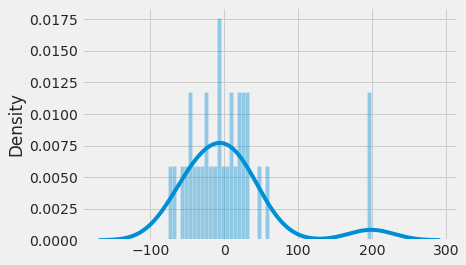

In [54]:
# Analisando os resíduos do modelo linear-learner do sagemaker
sns.distplot((y_test - predictions_test), bins=50);

É uma prática comum examinar os resíduos de problemas de regressão Um resíduo de uma observação nos dados de avaliação é a diferença entre o destino verdadeiro e o previsto. Os resíduos representam a parte do destino que o modelo não consegue prever. Um resíduo positivo indica que o modelo subestima o destino (o destino real é maior do que o previsto).

# **8. Excluindo Endpoint**

Exclua o endpoint ao final do uso para evitar cobranças

In [ ]:
sagemaker.Session().delete_endpoint(linear_regressor.endpoint_name)
print(f"deleted {multi_linear_regressor.endpoint_name} successfully!")

É importante salientar que a pouca quantidade de amostras impacta consideravelmente no resultado do modelo.

E também existem modelos mais sofisticados para realizar o treinamento. Todavia, o objetivo aqui foi capturar os dados da AWS e realizar o treinamento local.

# **9. Conclusão**

Observando o resultado do DataFrame acima do modelo `linear-learner` do SageMaker e os resultados dos modelos de Regressão Linear (Múltipla e Simples) que treinamos localmente (**notebook: model-ml-platform.ipynb**) podemos observar que o modelo do SageMaker obteve melhores resultados.

Pois como foi explicado anteriormente, quanto menor os valores das métricas `MAE`, `MSE` e `RMSE` melhor é o modelo, enquanto que o valor da métrica `R2` foi superior, o que também indica melhores resultados.

É importante salientar que a pouca quantidade de amostras impacta consideravelmente no resultado do modelo.

Observação: Existem modelos mais sofisticados para realizar o treinamento. Todavia, o objetivo aqui foi capturar os dados da AWS, integrar o modelo treinado na arquitetura existente e fazer o seu uso posterior.

# **Referências**

https://medium.com/@douglasheberteempty/ml-m%C3%A9tricas-de-regress%C3%A3o-20c1ed73c7e7

https://www.freecodecamp.org/news/machine-learning-mean-squared-error-regression-line-c7dde9a26b93/

https://www.investopedia.com/terms/r/r-squared.asp

https://docs.aws.amazon.com/pt_br/machine-learning/latest/dg/regression.html